**Hotel Booking Cancellation Tendency**

# 1. Business Understanding

## 1.1 Problem Statement

Sebuah perusahaan yang bergerak di bidang perhotelan di Portugal ingin mengurangi kerugian yang dialami dengan mengetahui kecenderungan terhadap pembatalan pesanan kamar dari customer. Pembatalan pesanan kamar yang secara tiba-tiba membuat kamar tersebut tidak dapat disewakan ke customer lain sehingga akan berpengaruh terhadap pendapatan dan perencanaan operasional perusahaan.

## 1.2 Goals



Tujuan kita adalah untuk membangun pemodelan Machine Learning yang dapat memprediksi apakah seorang customer memiliki kecenderungan untuk membatalkan pesanan mereka atau tidak. Pemodelan Machine Learning nantinya akan mempelajari karakteristik dari customer yang membatalkan pesanan mereka dan customer yang tidak membatalkan pesanan berdasarkan riwayat pemesanan yang telah ada.
<br>

**Confusion Matrix**

Actual/Prediction | 1 (Predicted Cancel) | 0 (Predicted Not_Cancel)
-----|-----|-----
1 (Actual Cancel)|True-Positive|`False-Negative`
0 (Actual Not_Cancel)|`False-Positive`|True-Negative

- True-Positive : Machine Learning memprediksi pesanan dibatalkan dan secara aktual customer membatalkan pesanan.
- `False-Positive` : Machine Learning memprediksi pesanan dibatalkan, namun secara aktual customer tidak membatalkan pesanan.
- `False-Negative` : Machine Learning memprediksi pesanan tidak dibatalkan, namun secara aktual customer membatalkan pesanan.
- True-Negative : Machine Learning memprediksi pesanan tidak dibatalkan dan secara aktual customer tidak membatalkan pesanan.

Baik `False-Positive` maupun `False-Negative` dapat merugikan perusahaan. Namun, `False-Negative` akan memberikan dampak yang lebih besar terhadap perusahaan. Perusahaan dapat kehilangan keuntungan dikarenakan kamar yang seharusnya telah terpesan, pada kenyataannya dibatalkan. Perusahaan juga dapat kehilangan customer potensial yang bisa menyewa kamar tersebut, namun tidak dapat menyewa karena kamar telah terisi dan berakhir pembatalan. Oleh karena itu, penting bagi kita untuk meminimalkan `False-Negative` yang terjadi, yang berarti kita harus memaksimalkan `recall` untuk Class .

# 2. Dataset Overview

## 2.1 Import Libraries

In [37]:
!pip install category_encoders

In [38]:
# Library

import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import missingno
from IPython.display import display
import plotly.express as px

# Feature Engineering
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
import category_encoders as ce

# Model Selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split, cross_val_score, RandomizedSearchCV, KFold
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score
from sklearn.svm import SVC

# Imbalance Dataset
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler

# Ignore Warning
import sys
import warnings
warnings.filterwarnings("ignore")

# Set max columns
pd.set_option('display.max_columns', None)

In [39]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [40]:
%cd /content/drive/My Drive/Purwadhika/Hotel Booking Demand/

/content/drive/My Drive/Purwadhika/Hotel Booking Demand


In [41]:
# Load Dataset
df = pd.read_csv("data_hotel_booking_demand.csv")
df

,country,market_segment,previous_cancellations,booking_changes,deposit_type,days_in_waiting_list,customer_type,reserved_room_type,required_car_parking_spaces,total_of_special_requests,is_canceled
0,IRL,Offline TA/TO,0,0,No Deposit,0,Transient-Party,A,0,0,0
1,FRA,Online TA,0,0,No Deposit,0,Transient,A,0,2,0
2,PRT,Online TA,0,1,No Deposit,0,Transient,A,0,2,0
3,NLD,Online TA,0,0,No Deposit,0,Transient,A,0,1,1
4,PRT,Online TA,0,2,No Deposit,0,Transient,A,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...
83568,PRT,Online TA,0,0,No Deposit,0,Contract,A,0,3,1
83569,FRA,Online TA,0,0,No Deposit,0,Transient,D,0,2,0
83570,PRT,Online TA,0,1,No Deposit,0,Transient,D,0,3,0
83571,CN,Offline TA/TO,0,0,No Deposit,0,Transient-Party,A,0,0,0


## 2.2 Data Understanding

Attribute Information

| Attribute | Description |
| --- | --- |
| country | Country of origin. |
| market_segment | Market segment designation. |
| | “TA” means “Travel Agents” |
| | “TO” means “Tour Operators” |
| previous_cancellations | Number of previous bookings that were cancelled by the customer prior to the current booking. |
| booking_changes | Number of changes/amendments made to the booking from the moment the booking was entered on the PMS until the moment of check-in or cancellation. |
| deposit_type | Indication on if the customer made a deposit to guarantee the booking. |
| days_in_waiting_list | Number of days the booking was in the waiting list before it was confirmed to the customer. |
| customer_type | Type of booking. |
| | Contract : when the booking has an allotment or other type of contract associated to it |
| | Group : when the booking is associated to a group |
| | Transient : when the booking is not part of a group or contract, and is not associated to other Transient parties |
| | Transient Party : when the booking is transient, but is associated to at least other transient booking |
| reserved_room_type | Code of room type reserved. Code is presented instead of designation for anonymity reasons. |
| required_car_parking_space | Number of car parking spaces required by the customer. |
| total_of_special_request | Number of special requests made by the customer (e.g. twin bed or high floor). |
| is_canceled | Value indicating if the booking was canceled (1) or not (0). |

In [42]:
# Check Data Info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83573 entries, 0 to 83572
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   country                      83222 non-null  object
 1   market_segment               83573 non-null  object
 2   previous_cancellations       83573 non-null  int64 
 3   booking_changes              83573 non-null  int64 
 4   deposit_type                 83573 non-null  object
 5   days_in_waiting_list         83573 non-null  int64 
 6   customer_type                83573 non-null  object
 7   reserved_room_type           83573 non-null  object
 8   required_car_parking_spaces  83573 non-null  int64 
 9   total_of_special_requests    83573 non-null  int64 
 10  is_canceled                  83573 non-null  int64 
dtypes: int64(6), object(5)
memory usage: 7.0+ MB


In [43]:
# Menghitung jumlah baris pada data awal
num_rows = len(df)
print("Number of rows :", num_rows)

Number of rows : 83573


Insights:
- Pada dataset ini terdapat `83.573 baris` dan `11 kolom` dimana tipe datanya terdiri dari `object` dan `int64`.
- Pada kolom `country` terdapat missing values.

## 2.3 Numerical Variables

In [44]:
# Melihat statistik variabel numerik
df.describe().T

,count,mean,std,min,25%,50%,75%,max
previous_cancellations,83573.0,0.086798,0.841011,0.0,0.0,0.0,0.0,26.0
booking_changes,83573.0,0.220897,0.648635,0.0,0.0,0.0,0.0,21.0
days_in_waiting_list,83573.0,2.330561,17.673051,0.0,0.0,0.0,0.0,391.0
required_car_parking_spaces,83573.0,0.062999,0.246919,0.0,0.0,0.0,0.0,8.0
total_of_special_requests,83573.0,0.573211,0.795163,0.0,0.0,0.0,1.0,5.0
is_canceled,83573.0,0.368277,0.482340,0.0,0.0,0.0,1.0,1.0


Insights:
- Rata-rata pengunjung telah membatalkan pesanan sebanyak 0,09 kali sebelumnya, dengan beberapa pengunjung telah membatalkan sebanyak 26 kali sebelumnya.
- Pengunjung mengubah pesanan rata-rata sekitar 0,22 kali, dengan beberapa pesanan diubah hingga 21 kali.\
- Waktu yang dibutuhkan oleh pengunjung untuk menunggu dalam antrian sekitar 2,3 hari, dengan beberapa pengunjung perlu menunggu hingga 391 hari.
- Rata-rata pengunjung membutuhkan sekitar 0,06 lahan parkir, dengan beberapa pengunjung membutuhkan hingga 8 lahan parkir.
- Pengunjung rata-rata membuat sekitar 0,57 permintaan khusus, dengan beberapa pengunjung membuat hingga 5 permintaan khusus.

## 2.4 Categorical Variables

In [45]:
# Membuat dataframe yang berisi kolom categorical
df_cat = df.select_dtypes(include = ['object'])

# Melihat statistik categorical variables
df_cat.describe().T

,count,unique,top,freq
country,83222,162,PRT,34097
market_segment,83573,8,Online TA,39460
deposit_type,83573,3,No Deposit,73352
customer_type,83573,4,Transient,62732
reserved_room_type,83573,10,A,60041


Insights:
- Terdapat 162 negara asal pengunjung, dimana yang paling banyak berasal dari `PRT` dengan total 34.097.
- Pada kolom `market_segment` terdapat 8 nilai unik, dengan `Online TA` merupakan nilai terbanyak.
- Tipe deposit terdiri dari 3 tipe dimana `No Deposit` merupakan tipe deposit yang paling banyak digunakan.
- Tipe customer terdiri dari 4 tipe dimana tipe customer yang paling banyak adalah `Transient`.
- Terdapat 10 tipe kamar yang dipesan, dengan tipe `A` merupakan tipe yang paling banyak dipesan.

# 3. Data Pre Processing

## 3.1 Feature Selection and Engineering



In [46]:
# Membuat kolom jumlah unique values dan missing values
unique_cat = df_cat.nunique()
missing_values = df_cat.isnull().sum()

# Menggabungkan dua variabel diatas ke dalam satu dataframe
cardinality = pd.DataFrame({'unique_categories' : unique_cat, 'missing_values' : missing_values})

cardinality

,unique_categories,missing_values
country,162,351
market_segment,8,0
deposit_type,3,0
customer_type,4,0
reserved_room_type,10,0


Insights:
- Kolom `country` memiliki 162 `unique_categories` dan 351 `missing_values`. Jumlah yang cukup banyak ini memungkinkan tidak adanya informasi spesifik untuk pemodelan. Untuk itu, variabel `country` dapat dianggap tidak relevan dan harus dihapus.

In [47]:
# Menghapus kolom country
df = df.drop(['country'], axis = 1)
df.head()

,market_segment,previous_cancellations,booking_changes,deposit_type,days_in_waiting_list,customer_type,reserved_room_type,required_car_parking_spaces,total_of_special_requests,is_canceled
0,Offline TA/TO,0,0,No Deposit,0,Transient-Party,A,0,0,0
1,Online TA,0,0,No Deposit,0,Transient,A,0,2,0
2,Online TA,0,1,No Deposit,0,Transient,A,0,2,0
3,Online TA,0,0,No Deposit,0,Transient,A,0,1,1
4,Online TA,0,2,No Deposit,0,Transient,A,0,2,0


## 3.2. Missing Values

In [48]:
# Mengecek data kosong
df.isnull().sum()

market_segment                 0
previous_cancellations         0
booking_changes                0
deposit_type                   0
days_in_waiting_list           0
customer_type                  0
reserved_room_type             0
required_car_parking_spaces    0
total_of_special_requests      0
is_canceled                    0
dtype: int64

Insights:
- Dataframe sudah tidak memiliki nilai kosong

## 3.3 Encode Categorical Variables

### 3.3.1 One Hot Encoding

One Hot Encoding dilakukan pada variabel kategori yang tidak memiliki urutan. One Hot Encoding mengubah setiap nilai menjadi kolom dengan angka 1 atau 0 untuk menunjukkan keberadaan nilai tersebut.

In [49]:
# One Hot Encoding
ohe = ['market_segment', 'reserved_room_type', 'deposit_type', 'customer_type']

df = pd.get_dummies(df, columns = ohe, drop_first = True)

# Mengubah spasi dengan '-'
df.columns = df.columns.str.replace(' ', '-')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83573 entries, 0 to 83572
Data columns (total 27 columns):
 #   Column                         Non-Null Count  Dtype
---  ------                         --------------  -----
 0   previous_cancellations         83573 non-null  int64
 1   booking_changes                83573 non-null  int64
 2   days_in_waiting_list           83573 non-null  int64
 3   required_car_parking_spaces    83573 non-null  int64
 4   total_of_special_requests      83573 non-null  int64
 5   is_canceled                    83573 non-null  int64
 6   market_segment_Complementary   83573 non-null  bool 
 7   market_segment_Corporate       83573 non-null  bool 
 8   market_segment_Direct          83573 non-null  bool 
 9   market_segment_Groups          83573 non-null  bool 
 10  market_segment_Offline-TA/TO   83573 non-null  bool 
 11  market_segment_Online-TA       83573 non-null  bool 
 12  market_segment_Undefined       83573 non-null  bool 
 13  reserved_room_ty

## 3.4 Check Imbalanced Data

Kita perlu melakukan pengecekan terhadap ketidakseimbangan data. Jika salah satu data memiliki proporsi lebih dari 80%, maka kita dapat mengkategorikan data tersebut tidak seimbang. Data yang tidak seimbang ini akan mempengaruhi pemodelan nantinya. Dikarenakan target variable disini adalah kolom `is_canceled`, maka yang akan kita cek ketidakseimbangan data adalah kolom tersebut.

In [50]:
# Jumlah pesanan yang dibatalkan dan tidak dibatalkan
cancel = df.groupby('is_canceled').agg(total = ('is_canceled', 'count')).reset_index()
cancel

,is_canceled,total
0,0,52795
1,1,30778


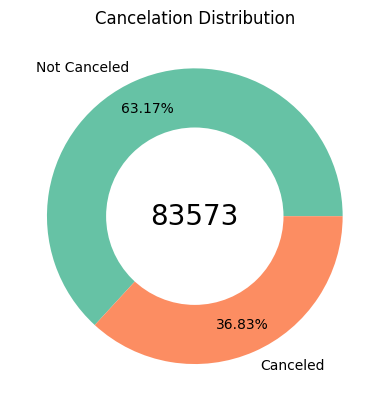

In [51]:
color = sns.color_palette("Set2")

plt.pie(data = cancel,
        x = 'total',
        labels = ['Not Canceled', 'Canceled'],
        pctdistance = 0.8,
        autopct = '%0.2f%%',
        colors = color)

fig = plt.gcf()
centre_circle = plt.Circle((0, 0), 0.6, fc = 'white')
fig.gca().add_artist(centre_circle)

plt.title('Cancelation Distribution')
plt.text(0, 0, len(df), ha = 'center', va = 'center', fontsize = 20)

plt.show()

Kita dapat melihat bahwa perbedaan proporsi pesanan yang tidak dibatalkan sebesar 63,17% dan yang dibatalkan sebesar 36.83%. Dikarenakan salah satu datanya tidak mencapai 80%, maka data ini masih dapat ditolerir sehingga kita tidak perlu melakukan penanganan pada data ini.

## 3.5 Split Dataset

In [52]:
# X sebagai dependent variables/features
X = df.drop(['is_canceled'], axis = 1)

# y sebagai target variable/output labels
y = df['is_canceled']

In [53]:
# Stratify = y -> untuk memastikan distribusi pada dataset asli tetap dipertahankan baik data pada train dan test
# Melakukan split data menjadi train dan test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

In [54]:
# Mengecek shape dari features
print(X_train.shape, X_test.shape)

(66858, 26) (16715, 26)


# 4. Model Building

In [60]:
# Membuat fungsi untuk menampilkan nilai Evaluation Matrix

def evaluation(model, X_train, X_test, y_train, y_test, name):
    model_building = model.fit(X_train, y_train)

    y_pred_train = model_building.predict(X_train)
    acc_train = accuracy_score(y_train, y_pred_train)
    prec_train = precision_score(y_train, y_pred_train)
    rec_train = recall_score(y_train, y_pred_train)
    f1_train = f1_score(y_train, y_pred_train)

    y_pred_test = model_building.predict(X_test)
    acc_test = accuracy_score(y_test, y_pred_test)
    prec_test = precision_score(y_test, y_pred_test)
    rec_test = recall_score(y_test, y_pred_test)
    f1_test = f1_score(y_test, y_pred_test)

    data_eva = {name + ' (Training)' : [acc_train, prec_train, rec_train, f1_train],
            name + ' (Testing)' : [acc_test, prec_test, rec_test, f1_test]}

    df_eva = (pd.DataFrame(data_eva, index = ['Accuracy', 'Precision', 'Recall', 'F1']).T).round(4)
    class_train = classification_report(y_train, y_pred_train)
    conf_train = confusion_matrix(y_train, y_pred_train, labels = [1, 0])
    df_train = pd.DataFrame(data = conf_train, columns = ['Predicted 1', 'Predicted 0'], index = ['Actual 1','Actual 0'])

    class_test = classification_report(y_test, y_pred_test)
    conf_test = confusion_matrix(y_test, y_pred_test, labels = [1, 0])
    df_test = pd.DataFrame(data = conf_test, columns = ['Predicted 1', 'Predicted 0'], index = ['Actual 1','Actual 0'])

    return df_eva, class_train, df_train, class_test, df_test

## 4.1 Logistic Regression

Model - Cancellation Detection<br>
Class 0 - No Cancellation Detected -> Negative<br>
Class 1 - Cancellation Detected -> Positive<br>
GOALS : Minimalized False-Negative (no cancellation detected but actually it does)<br>
Model will focus on Recall Class 1

In [ ]:
# Membuat base model Logistic Regression
logreg = LogisticRegression()

# Fitting ke dalam feature
logreg.fit(X_train, y_train)

LogisticRegression()

In [ ]:
# Menjalankan fungsi untuk Logistic Regression
df_logreg, class_train_logreg, conf_train_logreg, class_test_logreg, conf_test_logreg = evaluation(logreg,
                                                                                                   X_train,
                                                                                                   X_test,
                                                                                                   y_train,
                                                                                                   y_test,
                                                                                                   'Logistic Regression Base')

In [ ]:
# Menampilkan hasil Evaluation Matrix
df_logreg

,Accuracy,Precision,Recall,F1
Logistic Regression Base (Training),0.7966,0.7922,0.6067,0.6872
Logistic Regression Base (Testing),0.7967,0.7986,0.5991,0.6846


In [ ]:
# Menampilkan hasil Classification Report
print("\n\t Classification Report - Logistic Regression Base (Training)")
print("-" * 50)
print(class_train_logreg)

print("\n\t Classification Report - Logistic Regression Base (Testing)")
print("-" * 50)
print(class_test_logreg)


	 Classification Report - Logistic Regression Base (Training)
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.80      0.91      0.85     42236
           1       0.79      0.61      0.69     24622

    accuracy                           0.80     66858
   macro avg       0.80      0.76      0.77     66858
weighted avg       0.80      0.80      0.79     66858


	 Classification Report - Logistic Regression Base (Testing)
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.80      0.91      0.85     10559
           1       0.80      0.60      0.68      6156

    accuracy                           0.80     16715
   macro avg       0.80      0.76      0.77     16715
weighted avg       0.80      0.80      0.79     16715



In [ ]:
# Menampilkan hasil Confusion Matrix (Training)
print("\n Confusion Matrix - Logistic Regression Base (Training)")
print("-" * 50)

conf_train_logreg


 Confusion Matrix - Logistic Regression Base (Training)
--------------------------------------------------


,Predicted 1,Predicted 0
Actual 1,14939,9683
Actual 0,3918,38318


In [ ]:
# Menampilkan hasil Confusion Matrix (Testing)
print("\n Confusion Matrix - Logistic Regression Base (Testing)")
print("-" * 50)

conf_test_logreg


 Confusion Matrix - Logistic Regression Base (Testing)
--------------------------------------------------


,Predicted 1,Predicted 0
Actual 1,3688,2468
Actual 0,930,9629


## 4.2 Decision Tree

In [ ]:
# Membuat base model Decision Tree
dt = DecisionTreeClassifier()

# Fitting ke dalam feature
dt.fit(X_train, y_train)

DecisionTreeClassifier()

In [ ]:
# Menjalankan fungsi untuk Decision Tree
df_dt, class_train_dt, conf_train_dt, class_test_dt, conf_test_dt = evaluation(dt, X_train, X_test,
                                                                              y_train, y_test, 'Decision Tree Base')

In [ ]:
# Menampilkan hasil Evaluation Matrix
df_dt

,Accuracy,Precision,Recall,F1
Decision Tree Base (Training),0.8052,0.8012,0.6263,0.7030
Decision Tree Base (Testing),0.8028,0.8027,0.6158,0.6969


In [ ]:
# Menampilkan hasil Classification Report
print("\n\t Classification Report - Decision Tree Base (Training)")
print("-" * 50)
print(class_train_dt)

print("\n\t Classification Report - Decision Tree Base (Testing)")
print("-" * 50)
print(class_test_dt)


	 Classification Report - Decision Tree Base (Training)
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.81      0.91      0.86     42236
           1       0.80      0.63      0.70     24622

    accuracy                           0.81     66858
   macro avg       0.80      0.77      0.78     66858
weighted avg       0.80      0.81      0.80     66858


	 Classification Report - Decision Tree Base (Testing)
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.80      0.91      0.85     10559
           1       0.80      0.62      0.70      6156

    accuracy                           0.80     16715
   macro avg       0.80      0.76      0.78     16715
weighted avg       0.80      0.80      0.80     16715



In [ ]:
# Menampilkan hasil Confusion Matrix (Training)
print("\n Confusion Matrix - Decision Tree Base (Training)")
print("-" * 50)

conf_train_dt


 Confusion Matrix - Decision Tree Base (Training)
--------------------------------------------------


,Predicted 1,Predicted 0
Actual 1,15420,9202
Actual 0,3825,38411


In [ ]:
# Menampilkan hasil Confusion Matrix (Testing)
print("\n Confusion Matrix - Decision Tree Base (Testing)")
print("-" * 50)

conf_test_dt


 Confusion Matrix - Decision Tree Base (Testing)
--------------------------------------------------


,Predicted 1,Predicted 0
Actual 1,3791,2365
Actual 0,932,9627


Insights:
- Hasil `accuracy score` yang didapatkan dari pemodelan `Decision Tree` sebesar 80,2% dimana pemodelan ini mampu memprediksi dengan tepat apakah pemesanan hotel akan dibatalkan atau tidak.
- Nilai `precision` untuk Class 1 (Cancel) sebesar 80% dimana sebanyak 80% pemesanan yang diprediksi dibatalkan pada akhirnya benar-benar dibatalkan.
- Nilai `recall` untuk Class 1 (Cancel) sebesar 62% yang berarti bahwa pemodelan ini dapat dengan tepat mengidentifikasi pembatalan yang sebenarnya sebesar 62%.

## 4.3 K-Nearest Neighbors (KNN)

In [ ]:
# Membuat base model KNN
knn = KNeighborsClassifier()

# Fitting ke dalam feature
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [61]:
# Menjalankan fungsi untuk KNN
df_knn, class_train_knn, conf_train_knn, class_test_knn, conf_test_knn = evaluation(knn, X_train, X_test,
                                                                                    y_train, y_test, 'KNN Base')

In [62]:
# Menampilkan hasil Evaluation Matrix
df_knn

,Accuracy,Precision,Recall,F1
KNN Base (Training),0.7378,0.6151,0.7698,0.6838
KNN Base (Testing),0.7376,0.6166,0.7604,0.6810


In [ ]:
# Menampilkan hasil Classification Report
print("\n\t Classification Report - KNN Base (Training)")
print("-" * 50)
print(class_train_knn)

print("\n\t Classification Report - KNN Base (Testing)")
print("-" * 50)
print(class_test_knn)


	 Classification Report - KNN Base (Training)
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.84      0.72      0.78     42236
           1       0.62      0.77      0.68     24622

    accuracy                           0.74     66858
   macro avg       0.73      0.74      0.73     66858
weighted avg       0.76      0.74      0.74     66858


	 Classification Report - KNN Base (Testing)
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.84      0.72      0.78     10559
           1       0.62      0.76      0.68      6156

    accuracy                           0.74     16715
   macro avg       0.73      0.74      0.73     16715
weighted avg       0.76      0.74      0.74     16715



In [ ]:
# Menampilkan hasil Confusion Matrix (Training)
print("\n Confusion Matrix - KNN Base (Training)")
print("-" * 50)

conf_train_knn


 Confusion Matrix - KNN Base (Training)
--------------------------------------------------


,Predicted 1,Predicted 0
Actual 1,18955,5667
Actual 0,11860,30376


In [ ]:
# Menampilkan hasil Confusion Matrix (Testing)
print("\n Confusion Matrix - KNN Base (Testing)")
print("-" * 50)

conf_test_knn


 Confusion Matrix - KNN Base (Testing)
--------------------------------------------------


,Predicted 1,Predicted 0
Actual 1,4681,1475
Actual 0,2911,7648


## 4.4 Random Forest

In [ ]:
# Membuat base model Random Forest
rf = RandomForestClassifier()

# Fitting ke dalam feature
rf.fit(X_train, y_train)

RandomForestClassifier()

In [ ]:
# Menjalankan fungsi untuk Random Forest
df_rf, class_train_rf, conf_train_rf, class_test_rf, conf_test_rf = evaluation(rf, X_train, X_test,
                                                                               y_train, y_test, 'Random Forest Base')

In [ ]:
# Menampilkan hasil Evaluation Matrix
df_rf

,Accuracy,Precision,Recall,F1
Random Forest Base (Training),0.8052,0.8002,0.6277,0.7035
Random Forest Base (Testing),0.8025,0.8013,0.6165,0.6968


In [ ]:
# Menampilkan hasil Classification Report
print("\n\t Classification Report - Random Forest Base (Training)")
print("-" * 50)
print(class_train_rf)

print("\n\t Classification Report - Random Forest Base (Testing)")
print("-" * 50)
print(class_test_rf)


	 Classification Report - Random Forest Base (Training)
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.81      0.91      0.85     42236
           1       0.80      0.63      0.70     24622

    accuracy                           0.81     66858
   macro avg       0.80      0.77      0.78     66858
weighted avg       0.80      0.81      0.80     66858


	 Classification Report - Random Forest Base (Testing)
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.80      0.91      0.85     10559
           1       0.80      0.62      0.70      6156

    accuracy                           0.80     16715
   macro avg       0.80      0.76      0.78     16715
weighted avg       0.80      0.80      0.80     16715



In [ ]:
# Menampilkan hasil Confusion Matrix (Training)
print("\n Confusion Matrix - Random Forest Base (Training)")
print("-" * 50)

conf_train_rf


 Confusion Matrix - Random Forest Base (Training)
--------------------------------------------------


,Predicted 1,Predicted 0
Actual 1,15455,9167
Actual 0,3860,38376


In [ ]:
# Menampilkan hasil Confusion Matrix (Testing)
print("\n Confusion Matrix - Random Forest Base (Testing)")
print("-" * 50)

conf_test_rf


 Confusion Matrix - Random Forest Base (Testing)
--------------------------------------------------


,Predicted 1,Predicted 0
Actual 1,3795,2361
Actual 0,941,9618


## 4.5 Support Vector Classifier (SVC)

In [ ]:
# Membuat base model SVC
svc = SVC()

# Fitting ke dalam feature
svc.fit(X_train, y_train)

SVC()

In [ ]:
# Menjalankan fungsi untuk SVC
df_svc, class_train_svc, conf_train_svc, class_test_svc, conf_test_svc = evaluation(svc, X_train, X_test,
                                                                                    y_train, y_test, 'SVC Base')

In [ ]:
# Menampilkan hasil Evaluation Matrix
df_svc

,Accuracy,Precision,Recall,F1
SVC Base (Training),0.7658,0.9602,0.3798,0.5443
SVC Base (Testing),0.7657,0.9579,0.3804,0.5446


In [ ]:
# Menampilkan hasil Classification Report
print("\n\t Classification Report - SVC Base (Training)")
print("-" * 50)
print(class_train_svc)

print("\n\t Classification Report - SVC Base (Testing)")
print("-" * 50)
print(class_test_svc)


	 Classification Report - SVC Base (Training)
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.73      0.99      0.84     42236
           1       0.96      0.38      0.54     24622

    accuracy                           0.77     66858
   macro avg       0.85      0.69      0.69     66858
weighted avg       0.82      0.77      0.73     66858


	 Classification Report - SVC Base (Testing)
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.73      0.99      0.84     10559
           1       0.96      0.38      0.54      6156

    accuracy                           0.77     16715
   macro avg       0.85      0.69      0.69     16715
weighted avg       0.82      0.77      0.73     16715



In [ ]:
# Menampilkan hasil Confusion Matrix (Training)
print("\n Confusion Matrix - SVC Base (Training)")
print("-" * 50)

conf_train_svc


 Confusion Matrix - SVC Base (Training)
--------------------------------------------------


,Predicted 1,Predicted 0
Actual 1,9352,15270
Actual 0,388,41848


In [ ]:
# Menampilkan hasil Confusion Matrix (Testing)
print("\n Confusion Matrix - SVC Base (Testing)")
print("-" * 50)

conf_test_svc


 Confusion Matrix - SVC Base (Testing)
--------------------------------------------------


,Predicted 1,Predicted 0
Actual 1,2342,3814
Actual 0,103,10456


## 4.6 Model Building Comparison

Seperti yang sudah dijelaskan di awal, tujuan dari pemodelan ini adalah untuk mengurangi nilai dari kasus `False-Negative` atau `Recall Class 1`, dimana pemodelan akan memprediksi pengunjung tidak membatalkan pesanan tetapi kenyataannya pengunjung membatalkan pesanan. Kita perlu mengurangi nilai dari kasus `False-Negative` serendah mungkin untuk menghindari hilangnya pendapatan dari kamar yang tidak tersewa.

Dikarenakan tahap ini masih berada pada model building, maka feature yang akan digunakan adalah training.

In [ ]:
# Membandingkan berdasarkan Evaluation Matrix
pd.concat([df_logreg, df_dt, df_knn, df_rf, df_svc])

,Accuracy,Precision,Recall,F1
Logistic Regression Base (Training),0.7966,0.7922,0.6067,0.6872
Logistic Regression Base (Testing),0.7967,0.7986,0.5991,0.6846
Decision Tree Base (Training),0.8052,0.8012,0.6263,0.7030
Decision Tree Base (Testing),0.8028,0.8027,0.6158,0.6969
KNN Base (Training),0.7378,0.6151,0.7698,0.6838
KNN Base (Testing),0.7376,0.6166,0.7604,0.6810
Random Forest Base (Training),0.8052,0.8002,0.6277,0.7035
Random Forest Base (Testing),0.8025,0.8013,0.6165,0.6968
SVC Base (Training),0.7658,0.9602,0.3798,0.5443
SVC Base (Testing),0.7657,0.9579,0.3804,0.5446


Setelah dilakukan perbandingan di antara 5 model building yang telah dibuat, nilai `Recall Testing` paling tinggi diberikan oleh pemodelan `K-Nearest Neighbors (KNN)` dengan nilai sebesar 0.76.

In [ ]:
# Membandingkan Confusion Matrix
print('Confusion Matrix - Logistic Regression (Training)')
print(conf_train_logreg)

print('=' * 60)

print('Confusion Matrix - Decision Tree (Training)')
print(conf_train_dt)

print('=' * 60)

print('Confusion Matrix - K-Nearest Neighbors (KNN) (Training)')
print(conf_train_knn)

print('=' * 60)

print('Confusion Matrix - Random Forest (Training)')
print(conf_train_rf)

print('=' * 60)

print('Confusion Matrix - Support Vector Classifier (SVC) (Training)')
print(conf_train_svc)

Confusion Matrix - Logistic Regression (Training)
          Predicted 1  Predicted 0
Actual 1        14939         9683
Actual 0         3918        38318
Confusion Matrix - Decision Tree (Training)
          Predicted 1  Predicted 0
Actual 1        15420         9202
Actual 0         3825        38411
Confusion Matrix - K-Nearest Neighbors (KNN) (Training)
          Predicted 1  Predicted 0
Actual 1        18955         5667
Actual 0        11860        30376
Confusion Matrix - Random Forest (Training)
          Predicted 1  Predicted 0
Actual 1        15455         9167
Actual 0         3860        38376
Confusion Matrix - Support Vector Classifier (SVC) (Training)
          Predicted 1  Predicted 0
Actual 1         9352        15270
Actual 0          388        41848


Apabila kita melihat berdasarkan Confusion Matrix dari masing-masing model building, maka kita akan mendapatkan model building `K-Nearest Neighbors (KNN)` merupakan model paling baik. Pada pemodelan ini, kasus `False-Negative` terdapat sebanyak 5667 kasus, terpaut cukup jauh dengan pemodelan lainnya. Untuk itulah kita hanya akan melakukan tuning pada pemodelan `K-Nearest Neighbors (KNN)`.

# 5. Hyperparameter Tuning for KNN

K-Nearest Neighbors (KNN) adalah sebuah metode non-parametrik yang paling banyak digunakan untuk klasifikasi dimana terdapat jumlah neighbours dan parameter.
<br>

> KNeighborsClassifier(n_neighbors = 5, p = 2, metric = 'minkowski')

*   n_neighbors : jumlah neighbors (defaultnya adalah 5)
*   p : Minkowski power parameter. Dimana p = 1, setara dengan Manhattan distance, dan p = 2, menunjukkan Euclidean distance.

In [ ]:
## Build Parameter for KNN Model
param_knn = {'n_neighbors' : range(1, 20, 1), ## 1, 2, up to 49
           'weights' : ['uniform', 'distance'],
           'p' : [1, 2]}

In [ ]:
# Fitting ke pemodelan
knn_grid = GridSearchCV(knn,
                      param_knn,
                      cv = StratifiedKFold(n_splits = 3),
                      verbose = 1,
                      scoring = 'recall')

knn_grid.fit(X_train, y_train)

Fitting 3 folds for each of 76 candidates, totalling 228 fits


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
             estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(1, 20), 'p': [1, 2],
                         'weights': ['uniform', 'distance']},
             scoring='recall', verbose=1)

In [ ]:
# Best score
knn_grid.best_score_

0.780844612116964

In [ ]:
# Best parameter yang menghasilkan best recall score
knn_grid.best_params_

{'n_neighbors': 1, 'p': 1, 'weights': 'uniform'}

In [56]:
knn_tuning = KNeighborsClassifier(n_neighbors = 1, p = 1, weights = 'uniform')

In [57]:
knn_tuning.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=1, p=1)

In [58]:
recall_score(y_train, knn_tuning.predict(X_train))

0.7660628706035253

In [74]:
# Menjalankan fungsi menggunakan data yang telah di-tuning
df_knn_grid_tuning, class_knn_grid_tuning_train, conf_knn_grid_tuning_train, class_knn_grid_tuning_test, conf_knn_grid_tuning_test = evaluation(knn_tuning, X_train, X_test, y_train, y_test, 'KNN Tuning')

In [66]:
# Menampilkan Evaluation Matrix
df_knn_grid_tuning

,Accuracy,Precision,Recall,F1
KNN Tuning (GridSearch) (Training),0.6980,0.5665,0.7661,0.6513
KNN Tuning (GridSearch) (Testing),0.6937,0.5631,0.7511,0.6437


In [ ]:
# Menampilkan hasil Classification Report
print("\n\t Classification Report - KNN Tuning (Training)")
print("-" * 50)
print(class_knn_grid_tuning_train)

print("\n\t Classification Report - KNN Tuning (Testing)")
print("-" * 50)
print(class_knn_grid_tuning_test)


	 Classification Report - KNN Tuning (Training)
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.83      0.66      0.73     42236
           1       0.57      0.77      0.65     24622

    accuracy                           0.70     66858
   macro avg       0.70      0.71      0.69     66858
weighted avg       0.73      0.70      0.70     66858


	 Classification Report - KNN Tuning (Testing)
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.82      0.66      0.73     10559
           1       0.56      0.75      0.64      6156

    accuracy                           0.69     16715
   macro avg       0.69      0.71      0.69     16715
weighted avg       0.73      0.69      0.70     16715



In [ ]:
# Menampilkan hasil Confusion Matrix (Training)
print("\n Confusion Matrix - KNN Tuning (Training)")
print("-" * 50)

conf_knn_grid_tuning_train


 Confusion Matrix - KNN Tuning (Training)
--------------------------------------------------


,Predicted 1,Predicted 0
Actual 1,18862,5760
Actual 0,14433,27803


In [ ]:
# Menampilkan hasil Confusion Matrix (Testing)
print("\n Confusion Matrix - KNN Tuning (Testing)")
print("-" * 50)

conf_knn_grid_tuning_test


 Confusion Matrix - KNN Tuning (Testing)
--------------------------------------------------


,Predicted 1,Predicted 0
Actual 1,4624,1532
Actual 0,3587,6972


# 6. Model Evaluation

In [68]:
# Membandingkan Evaluasi Matrix dari data yang telah di-tuning
pd.concat([df_knn, df_knn_grid_tuning])

,Accuracy,Precision,Recall,F1
KNN Base (Training),0.7378,0.6151,0.7698,0.6838
KNN Base (Testing),0.7376,0.6166,0.7604,0.6810
KNN Tuning (GridSearch) (Training),0.6980,0.5665,0.7661,0.6513
KNN Tuning (GridSearch) (Testing),0.6937,0.5631,0.7511,0.6437


In [69]:
# Membandingkan Classification Report dari data testing yang telah di-tuning
print("\n\t Classification Report - KNN Base (Training)")
print("-" * 50)
print(class_train_knn)

print("\n\t Classification Report - KNN Tuning (Training)")
print("-" * 50)
print(class_knn_grid_tuning_train)


	 Classification Report - KNN Base (Training)
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.84      0.72      0.78     42236
           1       0.62      0.77      0.68     24622

    accuracy                           0.74     66858
   macro avg       0.73      0.74      0.73     66858
weighted avg       0.76      0.74      0.74     66858


	 Classification Report - KNN Tuning (Training)
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.83      0.66      0.73     42236
           1       0.57      0.77      0.65     24622

    accuracy                           0.70     66858
   macro avg       0.70      0.71      0.69     66858
weighted avg       0.73      0.70      0.70     66858



In [72]:
# Membandingkan Confusion Matrix dari data testing yang telah di-tuning
print("\n Confusion Matrix - KNN Base (Training)")
print("-" * 50)
print(conf_train_knn)

print("\n Confusion Matrix - KNN Tuning (Training)")
print("-" * 50)
print(conf_knn_grid_tuning_train)


 Confusion Matrix - KNN Base (Training)
--------------------------------------------------
          Predicted 1  Predicted 0
Actual 1        18955         5667
Actual 0        11860        30376

 Confusion Matrix - KNN Tuning (Training)
--------------------------------------------------
          Predicted 1  Predicted 0
Actual 1        18862         5760
Actual 0        14433        27803


Dari kedua perbandingan antara `Base Model KNN` dan `Hyperparameter Tuning`, dapat disimpulkan bahwa pemodelan yang cocok untuk data ini adalah `Base Model KNN` dimana recall score nya mencapai 76.98% yang sejumlah 5667 kasus.

# Recommendations

## 7.1 Conclusion

*   Kita telah mendapatkan pemodelan Machine Learning terbaik dengan menggunakan `K-Nearest Neighbors (KNN)`.
*   Setelah dilakukan proses tuning, didapatkan kesimpulan bahwa `base model` dari KNN masih lebih baik.
*   Dari keseluruhan pemesanan yang dibatalkan, sebesar 77% dapat diprediksi dengan tepat oleh pemodelan yang dibuat.
*   Model ini memiliki batasan dimana fitur yang digunakan terbatas pada :<br>
    1) Segment pasar <br>
    2) Tipe deposit <br>
    3) Tipe customer <br>
    4) Tipe kamar yang dipesan <br>
    5) Pembatalan pesanan sebelumnya <br>
    6) Perubahan pesanan <br>
    7) Lamanya menunggu pemesanan <br>
    8) Kebutuhan tempat parkir <br>
    9) Banyaknya permintaan khusus

## 7.2 Recommendation

*   Dengan banyaknya tingkat pembatalan yang terjadi sebelumnya, perusahaan perlu mengevaluasi kembali peraturan mengenai pembatalan pesanan. Menerapkan aturan yang ketat dapat mengurangi tingkat pembatalan kedepannya.
*   Segera menghubungi customer yang berada pada antrian apabila customer yang telah melakukan pesanan sebelumnya terindikasi akan membatalkan pesanan.
*   Machine Learning ini dapat dikembangkan dengan menambahkan berbagai macam data seperti harga sewa perkamar.

# Saving Model

In [73]:
import pickle

filename = "KNN Base.sav"
pickle.dump(knn, open(filename, 'wb'))

Apabila kita bandingkan berdasarkan `Confusion Matrix`, maka dapat terlihat pula bahwa model building `K-Nearest Neighbors (KNN)` memiliki kasus terendah yaitu sebesar 5667 kasus. Melihat jarak kasus antara `K-Nearest Neighbors (KNN)` dan yang lainnya cukup jauh, maka kita hanya perlu menggunakan model building `K-Nearest Neighbors (KNN)` untuk dilakukan tuning.